Epoch [1/200], Loss: 0.1484
Epoch [11/200], Loss: 0.1116
Epoch [21/200], Loss: 0.0779
Epoch [31/200], Loss: 0.0521
Epoch [41/200], Loss: 0.0420
Epoch [51/200], Loss: 0.0366
Epoch [61/200], Loss: 0.0294
Epoch [71/200], Loss: 0.0232
Epoch [81/200], Loss: 0.0170
Epoch [91/200], Loss: 0.0114
Epoch [101/200], Loss: 0.0071
Epoch [111/200], Loss: 0.0045
Epoch [121/200], Loss: 0.0035
Epoch [131/200], Loss: 0.0032
Epoch [141/200], Loss: 0.0030
Epoch [151/200], Loss: 0.0027
Epoch [161/200], Loss: 0.0025
Epoch [171/200], Loss: 0.0023
Epoch [181/200], Loss: 0.0022
Epoch [191/200], Loss: 0.0020


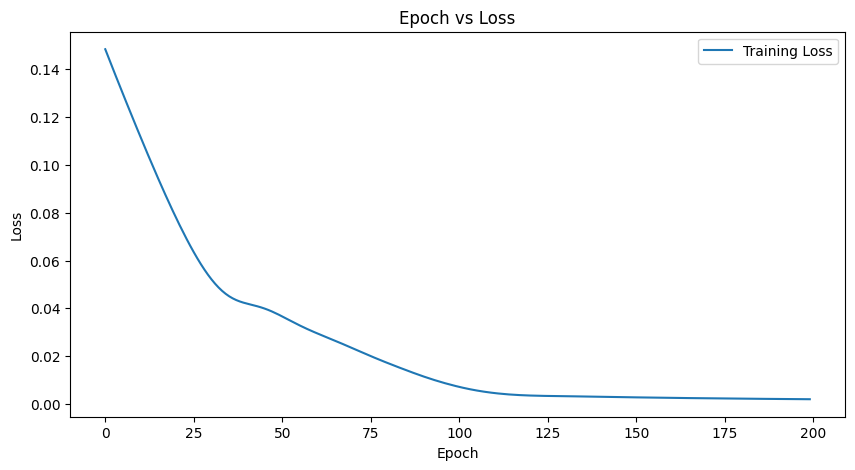

Test Loss (MSE): 0.0015
Accuracy (within 10.0% of actual): 76.92%


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        # Input gate layers
        self.W_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        # Forget gate layers
        self.W_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        # Output gate layers
        self.W_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Cell state layers
        self.W_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        # Output linear layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / torch.sqrt(torch.tensor([self.hidden_size], dtype=torch.float)).item()
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)


    def forward(self, x, init_states=None):
        bs, seq_sz, _ = x.size()
        hidden_seq = []

        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        for t in range(seq_sz):
            x_t = x[:, t, :]

            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        out = self.fc(hidden_seq[:, -1, :])
        return out, (h_t, c_t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

df = pd.read_csv('/content/NETFLIX_stocks.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

features = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

#Splitting the data into training and test set
train_data = scaled_features[:700]
test_data = scaled_features[700:]

# we are using 7 days to predict the next day
seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Model, optimizer, and loss function
model = LSTM(input_size=1, hidden_size=20, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training function
def train_model(model, X_train, y_train, num_epochs=200):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs, _ = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Training the model
train_model(model, X_train, y_train)
threshold_percentage=0.1

# Prediction function
def predict(model, X_test,y_test,threshold=0.1):
    model.eval()
    with torch.no_grad():
        outputs, _ = model(X_test)
        test_loss = criterion(outputs, y_test)
        diffs = torch.abs(outputs - y_test)
        correct = diffs < (threshold * torch.abs(y_test))
        accuracy = torch.mean(correct.float())

    print(f'Test Loss (MSE): {test_loss.item():.4f}')
    print(f'Accuracy (within {threshold_percentage*100}% of actual): {accuracy*100:.2f}%')

predictions = predict(model, X_test,y_test,threshold=threshold_percentage)


Epoch [1/200], Loss: 0.2190
Epoch [11/200], Loss: 0.0279
Epoch [21/200], Loss: 0.0200
Epoch [31/200], Loss: 0.0096
Epoch [41/200], Loss: 0.0025
Epoch [51/200], Loss: 0.0033
Epoch [61/200], Loss: 0.0018
Epoch [71/200], Loss: 0.0018
Epoch [81/200], Loss: 0.0016
Epoch [91/200], Loss: 0.0016
Epoch [101/200], Loss: 0.0016
Epoch [111/200], Loss: 0.0016
Epoch [121/200], Loss: 0.0016
Epoch [131/200], Loss: 0.0015
Epoch [141/200], Loss: 0.0015
Epoch [151/200], Loss: 0.0015
Epoch [161/200], Loss: 0.0015
Epoch [171/200], Loss: 0.0015
Epoch [181/200], Loss: 0.0015
Epoch [191/200], Loss: 0.0015


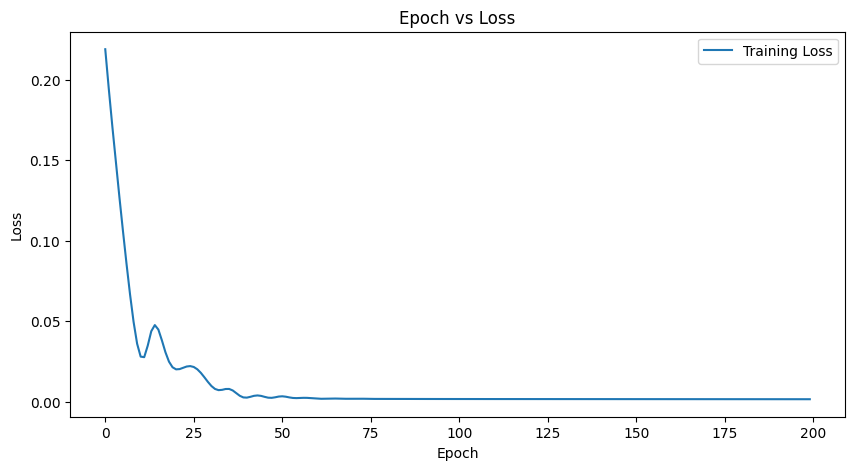

Test Loss (MSE): 0.0010
Accuracy (within 10.0% of actual): 85.62%


In [26]:
#LSTM for config 2

model_LSTM_2 = LSTM(input_size=1, hidden_size=20, output_size=1)
threshold_percentage = 0.1
optimizer = optim.Adam(model_LSTM_2.parameters(), lr=0.005)
criterion = nn.MSELoss()
train_model(model_LSTM_2, X_train, y_train)
predictions = predict(model_LSTM_2, X_test,y_test,threshold=threshold_percentage)

Epoch [1/200], Loss: 0.2767
Epoch [11/200], Loss: 0.1692
Epoch [21/200], Loss: 0.0838
Epoch [31/200], Loss: 0.0529
Epoch [41/200], Loss: 0.0469
Epoch [51/200], Loss: 0.0345
Epoch [61/200], Loss: 0.0251
Epoch [71/200], Loss: 0.0141
Epoch [81/200], Loss: 0.0053
Epoch [91/200], Loss: 0.0026
Epoch [101/200], Loss: 0.0030
Epoch [111/200], Loss: 0.0025
Epoch [121/200], Loss: 0.0024
Epoch [131/200], Loss: 0.0023
Epoch [141/200], Loss: 0.0023
Epoch [151/200], Loss: 0.0022
Epoch [161/200], Loss: 0.0022
Epoch [171/200], Loss: 0.0021
Epoch [181/200], Loss: 0.0021
Epoch [191/200], Loss: 0.0020


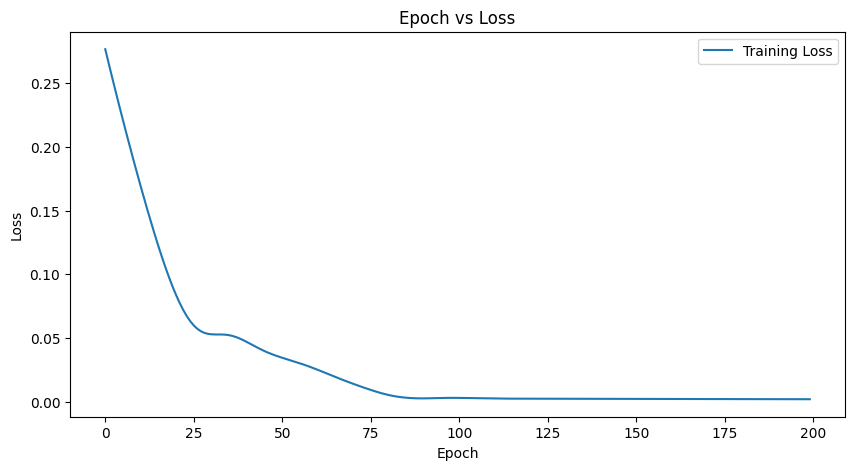

Test Loss (MSE): 0.0011
Accuracy (within 10.0% of actual): 82.61%


In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Weights for input and hidden tensors
        self.Wxh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))

        # Output layer weights
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / torch.sqrt(torch.tensor([self.hidden_size], dtype=torch.float)).item()
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, init_states=None):
        bs, seq_sz, _ = x.size()
        hidden_seq = []

       #we set hiddent state to zero if not provided( if not being carried over)
        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_states

        for t in range(seq_sz):
            x_t = x[:, t, :]

            h_t = torch.tanh(x_t @ self.Wxh + h_t @ self.Whh + self.bh)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        out = self.fc(hidden_seq[:, -1, :])

        return out, h_t

model_RNN = RNN(input_size=1, hidden_size=20, output_size=1)
threshold_percentage = 0.1
optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_model(model_RNN, X_train, y_train)
predictions = predict(model_RNN, X_test,y_test,threshold=threshold_percentage)



Epoch [1/200], Loss: 0.2306
Epoch [11/200], Loss: 0.0528
Epoch [21/200], Loss: 0.0221
Epoch [31/200], Loss: 0.0020
Epoch [41/200], Loss: 0.0032
Epoch [51/200], Loss: 0.0018
Epoch [61/200], Loss: 0.0013
Epoch [71/200], Loss: 0.0013
Epoch [81/200], Loss: 0.0011
Epoch [91/200], Loss: 0.0011
Epoch [101/200], Loss: 0.0010
Epoch [111/200], Loss: 0.0010
Epoch [121/200], Loss: 0.0009
Epoch [131/200], Loss: 0.0009
Epoch [141/200], Loss: 0.0009
Epoch [151/200], Loss: 0.0009
Epoch [161/200], Loss: 0.0009
Epoch [171/200], Loss: 0.0008
Epoch [181/200], Loss: 0.0008
Epoch [191/200], Loss: 0.0008


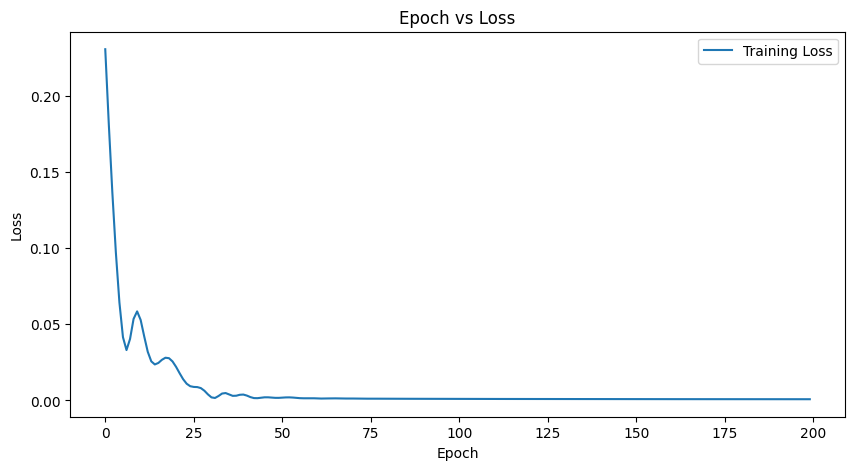

Test Loss (MSE): 0.0005
Accuracy (within 10.0% of actual): 95.32%


In [28]:
model_RNN_2 = RNN(input_size=1, hidden_size=20, output_size=1)
threshold_percentage = 0.1
optimizer = optim.Adam(model_RNN_2.parameters(), lr=0.005)
criterion = nn.MSELoss()
train_model(model_RNN_2, X_train, y_train)
predictions = predict(model_RNN_2, X_test,y_test,threshold=threshold_percentage)


Epoch [1/200], Loss: 0.2103
Epoch [11/200], Loss: 0.1443
Epoch [21/200], Loss: 0.0957
Epoch [31/200], Loss: 0.0636
Epoch [41/200], Loss: 0.0466
Epoch [51/200], Loss: 0.0410
Epoch [61/200], Loss: 0.0386
Epoch [71/200], Loss: 0.0351
Epoch [81/200], Loss: 0.0316
Epoch [91/200], Loss: 0.0282
Epoch [101/200], Loss: 0.0244
Epoch [111/200], Loss: 0.0204
Epoch [121/200], Loss: 0.0160
Epoch [131/200], Loss: 0.0115
Epoch [141/200], Loss: 0.0072
Epoch [151/200], Loss: 0.0037
Epoch [161/200], Loss: 0.0018
Epoch [171/200], Loss: 0.0014
Epoch [181/200], Loss: 0.0014
Epoch [191/200], Loss: 0.0014


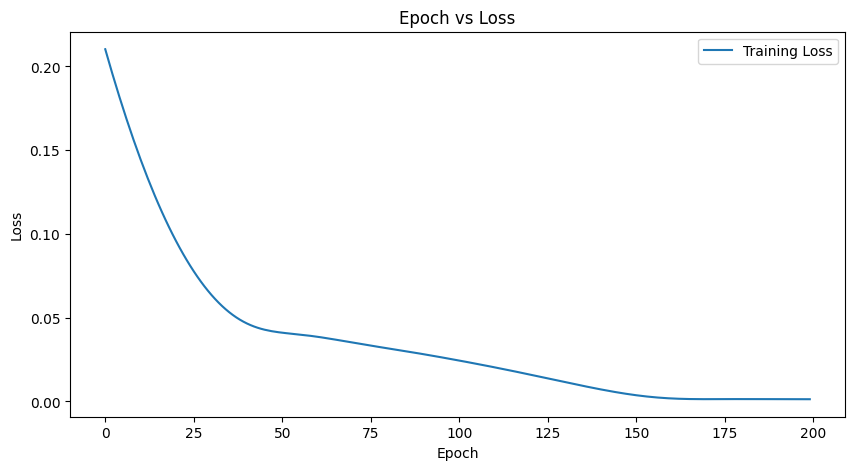

Test Loss (MSE): 0.0009
Accuracy (within 10.0% of actual): 86.29%


In [29]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size

        # Reset gate
        self.W_ir = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hr = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.Tensor(hidden_size))

        # Update gate
        self.W_iz = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.Tensor(hidden_size))

        # New gate
        self.W_in = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hn = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_n = nn.Parameter(torch.Tensor(hidden_size))

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / torch.sqrt(torch.tensor([self.hidden_size], dtype=torch.float)).item()
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, init_states=None):
        bs, seq_sz, _ = x.size()
        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t = init_states

        for t in range(seq_sz):
            x_t = x[:, t, :]

            # Reset gate
            r_t = torch.sigmoid(x_t @ self.W_ir + h_t @ self.W_hr + self.b_r)

            # Update gate
            z_t = torch.sigmoid(x_t @ self.W_iz + h_t @ self.W_hz + self.b_z)

            # New gate
            n_t = torch.tanh(x_t @ self.W_in + (r_t * h_t) @ self.W_hn + self.b_n)

            # Update hidden state
            h_t = (1 - z_t) * n_t + z_t * h_t

        # Compute the output
        out = self.fc(h_t)

        return out, h_t

model_GRU = GRU(input_size=1, hidden_size=20, output_size=1)
threshold_percentage = 0.1
optimizer = optim.Adam(model_GRU.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_model(model_GRU, X_train, y_train)
predictions = predict(model_GRU, X_test,y_test,threshold=threshold_percentage)


Epoch [1/200], Loss: 0.4698
Epoch [11/200], Loss: 0.0454
Epoch [21/200], Loss: 0.0365
Epoch [31/200], Loss: 0.0330
Epoch [41/200], Loss: 0.0210
Epoch [51/200], Loss: 0.0136
Epoch [61/200], Loss: 0.0071
Epoch [71/200], Loss: 0.0021
Epoch [81/200], Loss: 0.0013
Epoch [91/200], Loss: 0.0013
Epoch [101/200], Loss: 0.0011
Epoch [111/200], Loss: 0.0011
Epoch [121/200], Loss: 0.0011
Epoch [131/200], Loss: 0.0011
Epoch [141/200], Loss: 0.0010
Epoch [151/200], Loss: 0.0010
Epoch [161/200], Loss: 0.0010
Epoch [171/200], Loss: 0.0010
Epoch [181/200], Loss: 0.0010
Epoch [191/200], Loss: 0.0010


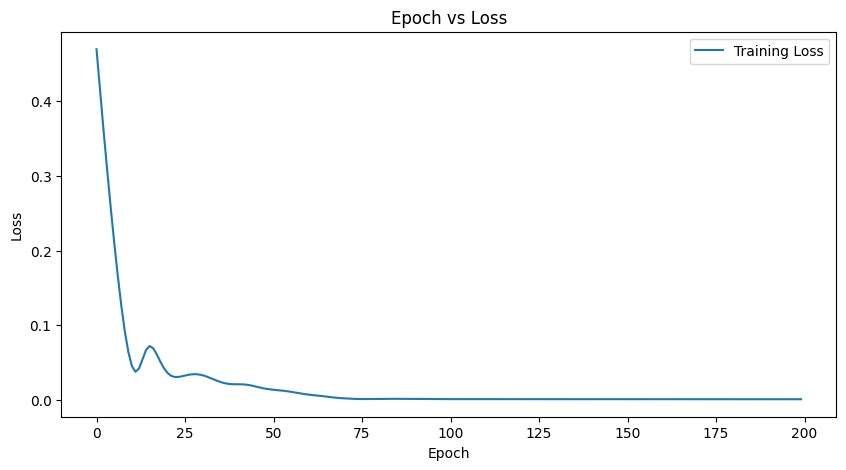

Test Loss (MSE): 0.0006
Accuracy (within 10.0% of actual): 92.64%


In [30]:
model_GRU_2 = GRU(input_size=1, hidden_size=20, output_size=1)
threshold_percentage = 0.1
optimizer = optim.Adam(model_GRU_2.parameters(), lr=0.005)
criterion = nn.MSELoss()
train_model(model_GRU_2, X_train, y_train)
predictions = predict(model_GRU_2, X_test,y_test,threshold=threshold_percentage)
